<a href="https://colab.research.google.com/github/edugalt/hSBM_Topicmodel/blob/master/TopSBM-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Graph-Tool in Colab

[https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb#scrollTo=ccAj89hUOqoU](https://colab.research.google.com/github/count0/colab-gt/blob/master/colab-gt.ipynb#scrollTo=ccAj89hUOqoU)

In [ ]:
!wget https://downloads.skewed.de/skewed-keyring/skewed-keyring_1.0_all_$(lsb_release -s -c).deb
!dpkg -i skewed-keyring_1.0_all_$(lsb_release -s -c).deb
!echo "deb [signed-by=/usr/share/keyrings/skewed-keyring.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

--2024-10-20 23:55:15--  https://downloads.skewed.de/skewed-keyring/skewed-keyring_1.0_all_jammy.deb
Resolving downloads.skewed.de (downloads.skewed.de)... 49.12.93.194
Connecting to downloads.skewed.de (downloads.skewed.de)|49.12.93.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23192 (23K) [application/x-debian-package]
Saving to: ‘skewed-keyring_1.0_all_jammy.deb’

skewed-keyring_1.0_ 100%[===================>]  22.65K  --.-KB/s    in 0.1s    

2024-10-20 23:55:16 (172 KB/s) - ‘skewed-keyring_1.0_all_jammy.deb’ saved [23192/23192]

Selecting previously unselected package skewed-keyring.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack skewed-keyring_1.0_all_jammy.deb ...
Unpacking skewed-keyring (1.0) ...
Setting up skewed-keyring (1.0) ...
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129

In [ ]:
# Colab uses a Python install that deviates from the system's! Bad colab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 50 not upgraded.
After this operation, 310 kB disk space will be freed.
(Reading database ... 132030 files and directories currently installed.)
Removing python3-cairo:amd64 (1.20.1-3build1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libblkid-dev libblkid1 libcairo-script-interpreter2 libffi-dev libglib2.0-dev libglib2.0-dev-bin
  libice-dev liblzo2-2 libmount-dev libmount1 libpixman-1-dev libselinux1-dev libsepol-dev
  lib

In [ ]:
!git clone https://github.com/edugalt/hSBM_Topicmodel.git
!cp hSBM_Topicmodel/corpus.txt .
!cp hSBM_Topicmodel/titles.txt .
!cp hSBM_Topicmodel/sbmtm.py .

Cloning into 'hSBM_Topicmodel'...
remote: Enumerating objects: 398, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 398 (delta 64), reused 44 (delta 40), pack-reused 311 (from 1)
Receiving objects: 100% (398/398), 28.82 MiB | 27.92 MiB/s, done.
Resolving deltas: 100% (126/126), done.


# TopSBM: Topic Modeling with Stochastic Block Models

A basic tutorial.


In [ ]:
%load_ext autoreload
%autoreload 2

import os
import pylab as plt
%matplotlib inline

from sbmtm import sbmtm
import graph_tool.all as gt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup: Load a corpus

1) We have a list of documents, each document contains a list of words.

2) We have a list of document titles (optional)

The example corpus consists of 63 articles from Wikipedia taken from 3 different categories (Experimental Physics, Chemical Physics, and Computational Biology).



In [ ]:
path_data = ''

## texts
fname_data = 'corpus.txt'
filename = os.path.join(path_data,fname_data)

with open(filename,'r', encoding = 'utf8') as f:
    x = f.readlines()
texts = [h.split() for h in x]

## titles
fname_data = 'titles.txt'
filename = os.path.join(path_data,fname_data)

with open(filename,'r', encoding = 'utf8') as f:
    x = f.readlines()
titles = [h.split()[0] for h in x]

In [ ]:
i_doc = 0
print(titles[0])
print(texts[i_doc][:10])


Nuclear_Overhauser_effect
['the', 'nuclear', 'overhauser', 'effect', 'noe', 'is', 'the', 'transfer', 'of', 'nuclear']


# Fitting the model

In [ ]:
## we create an instance of the sbmtm-class
model = sbmtm()

## we have to create the word-document network from the corpus
model.make_graph(texts,documents=titles)

## we can also skip the previous step by saving/loading a graph
# model.save_graph(filename = 'graph.xml.gz')
# model.load_graph(filename = 'graph.xml.gz')

## fit the model
gt.seed_rng(32) ## seed for graph-tool's random number generator --> same results
model.fit()

<NestedBlockState object, with base <BlockState object with 3203 blocks (67 nonempty), degree-corrected, for graph <Graph object, undirected, with 3203 vertices and 13050 edges, 2 internal vertex properties, 1 internal edge property, at 0x7ce584e5e8c0>, at 0x7ce584ce3a00>, and 5 levels of sizes [(3203, 67), (67, 14), (14, 3), (3, 2), (2, 1)] at 0x7ce584e5feb0>


# Plotting the result

The output shows the (hierarchical) community structure in the word-document network as inferred by the stochastic block model:

- document-nodes are on the left
- word-nodes are on the right
- different colors correspond to the different groups

The result is a grouping of nodes into groups on multiple levels in the hierarchy:

- on the uppermost level, each node belongs to the same group (square in the middle)
- on the next-lower level, we split the network into two groups: the word-nodes and the document-nodes (blue sqaures to the left and right, respectively). This is a trivial structure due to the bipartite character of the network.
- only next lower levels constitute a non-trivial structure: We now further divide nodes into smaller groups (document-nodes into document-groups on the left and word-nodes into word-groups on the right)

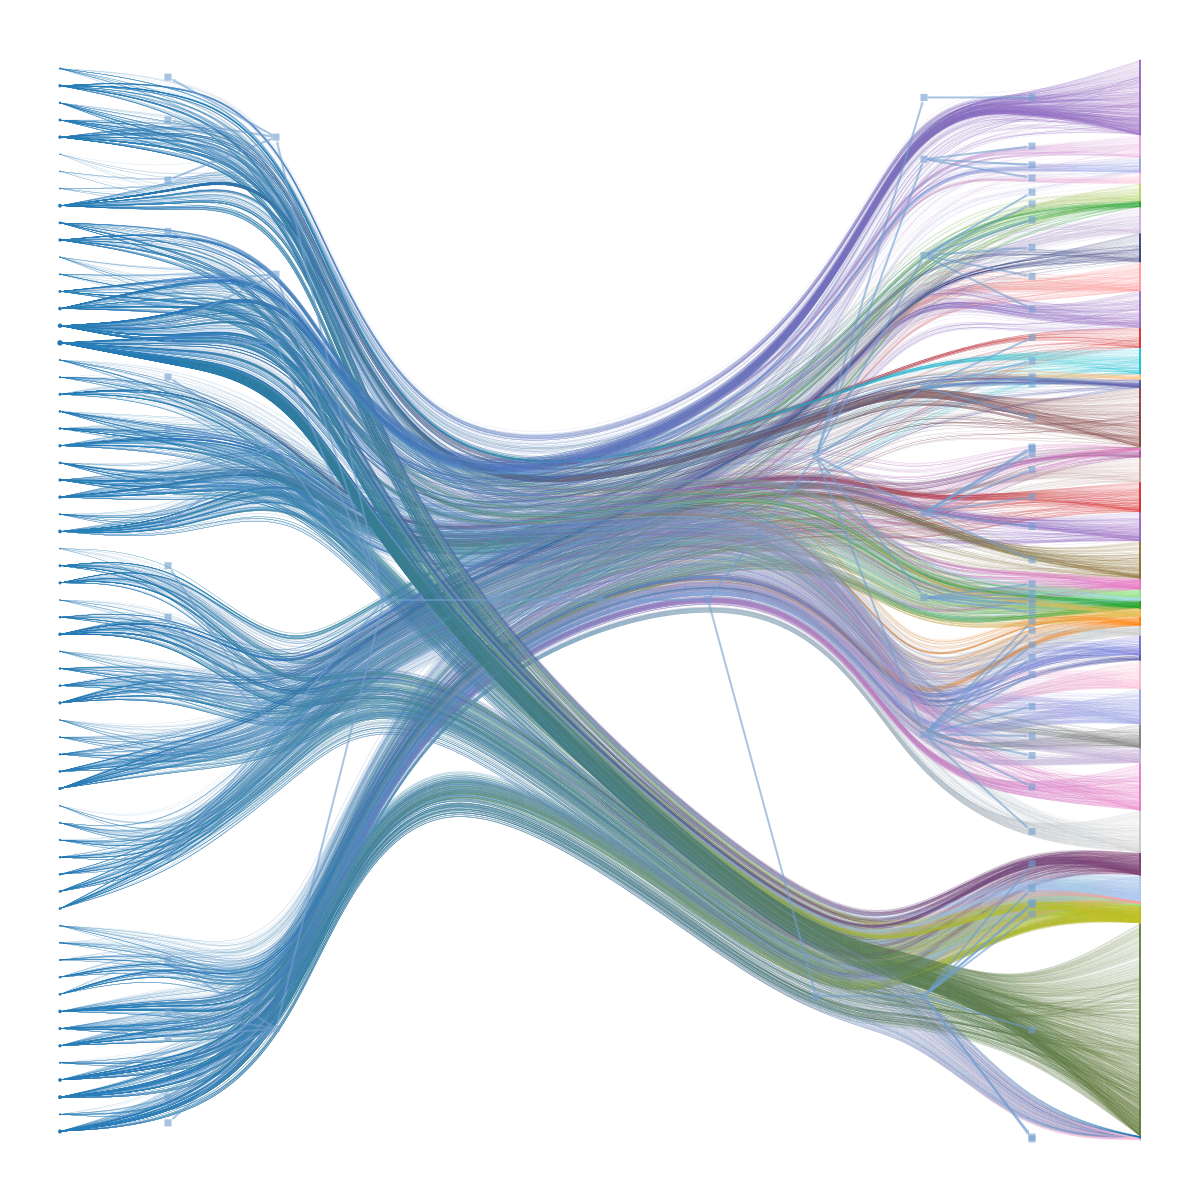

In [ ]:
model.plot(nedges=10000)

# The basics

## Topics
For each word-group on a given level in the hierarchy, we retrieve the $n$ most common words in each group -- these are the topics!


In [ ]:
model.topics(l=1,n=20)

{0: [('the', 0.14644638689304837),
  ('of', 0.08265067960276418),
  ('and', 0.051347764404375086),
  ('a', 0.047961191707473344),
  ('to', 0.04649672783854286),
  ('in', 0.04480344149009199),
  ('is', 0.03711500617820695),
  ('for', 0.019587204246945218),
  ('as', 0.018260033865726968),
  ('that', 0.01478193217701707),
  ('are', 0.014141229234359983),
  ('by', 0.013088645828566198),
  ('be', 0.0126767653654295),
  ('on', 0.011349594984211248),
  ('with', 0.011212301496499016),
  ('an', 0.011075008008786783),
  ('this', 0.010205482586609308),
  ('can', 0.009473250652144067),
  ('which', 0.009381721660335912),
  ('or', 0.00883254770948698)],
 1: [('formula', 0.07297019527235354),
  ('electron', 0.020897567660157587),
  ('electric', 0.018499486125385406),
  ('x', 0.017814319972593355),
  ('spin', 0.016101404590613225),
  ('surface', 0.0157588215142172),
  ('experimental', 0.014388489208633094),
  ('experiments', 0.013703323055841042),
  ('frequency', 0.01301815690304899),
  ('beam', 0.013

## Topic-distribution in each document
Which topics contribute to each document?

In [ ]:
## select a document (by its index)
i_doc = 0
print(model.documents[i_doc])
## get a list of tuples (topic-index, probability)
model.topicdist(i_doc,l=1)

Nuclear_Overhauser_effect


[(0, 0.5244755244755245),
 (1, 0.2762237762237762),
 (2, 0.013986013986013986),
 (3, 0.08391608391608392),
 (4, 0.06643356643356643),
 (5, 0.024475524475524476),
 (6, 0.006993006993006993),
 (7, 0.0034965034965034965)]

# Extra: Clustering of documents - for free.
The stochastic block models clusters the documents into groups.
We do not need to run an additional clustering to obtain this grouping.


In [ ]:
model.clusters(l=1,n=5)

{0: [('Wave_tank', 1.0),
  ('X-ray_standing_waves', 1.0),
  ('Rovibrational_coupling', 1.0),
  ('Dynamic_nuclear_polarisation', 1.0),
  ('Knight_shift', 1.0)],
 1: [('Quantum_oscillations_(experimental_technique)', 1.0),
  ('Einstein–de_Haas_effect', 1.0),
  ('Molecular_beam', 1.0),
  ('Line_source', 1.0),
  ('Electrostatic_deflection_(structural_element)', 1.0)],
 2: [('Magic_angle_(EELS)', 1.0),
  ('Law_of_Maximum', 1.0),
  ('Dynamic_mode_decomposition', 1.0),
  ('Fragment_separator', 1.0),
  ('Molecular_vibration', 1.0)],
 3: [('International_Society_for_Computational_Biology', 1.0),
  ('Foldit', 1.0),
  ('Knotted_protein', 1.0),
  ('IEEE/ACM_Transactions_on_Computational_Biology_and_Bioinformatics', 1.0),
  ('List_of_Directors_General_of_CERN', 1.0)],
 4: [('De_novo_transcriptome_assembly', 1.0),
  ('SnoRNA_prediction_software', 1.0),
  ('BioUML', 1.0),
  ('Computational_biology', 1.0),
  ('K-mer', 1.0)],
 5: [('Folding@home', 1.0)]}

Application -- Finding similar articles:

For a query-article, we return all articles from the same group

In [ ]:
## select a document (index)
i_doc = 2
print(i_doc,model.documents[i_doc])
## find all articles from the same group
## print: (doc-index, doc-title)
model.clusters_query(i_doc,l=1,)

2 Rovibrational_coupling


[(0, 'Nuclear_Overhauser_effect'),
 (6, 'Dynamic_nuclear_polarisation'),
 (7, 'Knight_shift'),
 (8, 'Polarizability'),
 (26, 'Ripple_tank'),
 (27, 'Particle-induced_X-ray_emission'),
 (31, 'Wave_tank'),
 (33, 'X-ray_crystal_truncation_rod'),
 (34, 'Faraday_cup_electrometer'),
 (36, 'X-ray_standing_waves')]

# More technical: Group membership
In the stochastic block model, word (-nodes) and document (-nodes) are clustered into different groups.

The group membership can be represented by the conditional probability $P(\text{group}\, |\, \text{node})$. Since words and documents belong to different groups (the word-document network is bipartite) we can show separately:

- P(bd | d), the probability of document $d$ to belong to document group $bd$
- P(bw | w), the probability of word $w$ to belong to word group $bw$.

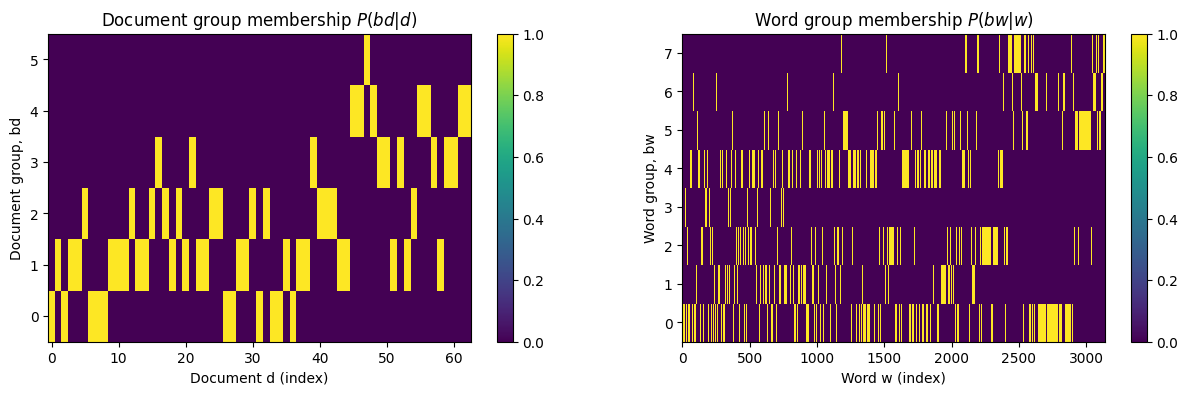

In [ ]:
p_td_d,p_tw_w = model.group_membership(l=1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.imshow(p_td_d,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Document group membership $P(bd | d)$')
plt.xlabel('Document d (index)')
plt.ylabel('Document group, bd')
plt.colorbar()

plt.subplot(122)
plt.imshow(p_tw_w,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Word group membership $P(bw | w)$')
plt.xlabel('Word w (index)')
plt.ylabel('Word group, bw')
plt.colorbar()

# Relative topical distribution

Compare the frequency $f^i_d$ of words from topic $i$ in document $d$ with the expected value across all documents:

$$ \tau_d^i = (f^i_d -\langle f^i \rangle ) / \langle f^i \rangle $$

as in Eq. (10) of Hyland et al.

In [ ]:
model.print_overview()

Level 0 has 22 document groups and 45 topics (word groups)
Level 1 has 6 document groups and 8 topics (word groups)
Level 2 has 1 document groups and 2 topics (word groups)
Level 3 has 1 document groups and 1 topics (word groups)



In [ ]:
model.topics(l=2)

{0: [('the', 0.14644638689304837),
  ('of', 0.08265067960276418),
  ('and', 0.051347764404375086),
  ('a', 0.047961191707473344),
  ('to', 0.04649672783854286),
  ('in', 0.04480344149009199),
  ('is', 0.03711500617820695),
  ('for', 0.019587204246945218),
  ('as', 0.018260033865726968),
  ('that', 0.01478193217701707)],
 1: [('formula', 0.011930767938161653),
  ('s', 0.010362404077746037),
  ('folding', 0.008906066207360107),
  ('was', 0.008682014227300734),
  ('protein', 0.007785806307063239),
  ('home', 0.007113650366885118),
  ('used', 0.006777572396796057),
  ('these', 0.005825351481543718),
  ('field', 0.005601299501484344),
  ('have', 0.005377247521424971)]}

Relative contribution of topics in each document

In [ ]:
print("Document title [relative contribution of each topic]\n")
tau_d=model.topicdist_relative(l=2)

for i in range(len(model.documents)):
    print(model.documents[i],tau_d[i])

Document title [relative contribution of each topic]

Nuclear_Overhauser_effect [-0.04701038  0.05753788]
Quantum_solvent [ 0.07403602 -0.09061565]
Rovibrational_coupling [-0.01561138  0.01910739]
Effective_field_theory [-0.0698986   0.08555168]
Chemical_physics [-0.04366656  0.05344524]
Rotational_transition [-0.04218387  0.05163052]
Dynamic_nuclear_polarisation [-0.11564032  0.14153681]
Knight_shift [-0.1550794   0.18980788]
Polarizability [-0.12731589  0.15582701]
Anisotropic_liquid [-0.09148323  0.11196998]
Rotating_wave_approximation [-0.04788837  0.05861249]
RRKM_theory [ 0.07075191 -0.08659609]
Molecular_vibration [-0.01946262  0.02382108]
Fuel_mass_fraction [-0.24014961  0.2939287 ]
Electrostatic_deflection_(structural_element) [-0.15504201  0.18976212]
Magic_angle_(EELS) [-0.00436518  0.00534272]
Reactive_empirical_bond_order [-0.12373826  0.1514482 ]
Photofragment-ion_imaging [ 0.00625679 -0.00765794]
Molecular_beam [-0.03852037  0.04714662]
McConnell_equation [-0.15962199  0

Documents associated to each of the topics

In [ ]:
model.docs_of_topic(l=2, n=10)


Topic 0
[0.2621092573665301, 'Folding@home']
[0.19476178326060117, 'Law_of_Maximum']
[0.07403602277256145, 'Quantum_solvent']
[0.07075191066770405, 'RRKM_theory']
[0.06884326198558693, 'Aureus_Sciences']
[0.04731794629282152, 'Wave_tank']
[0.04706251535133269, 'Uncertainty']
[0.04374673256370313, 'BioUML']
[0.025454575112904557, 'Knotted_protein']
[0.02208136927371747, 'Holometer']

Topic 1
[0.5289587184226741, 'List_of_Directors_General_of_CERN']
[0.2939287005494365, 'Fuel_mass_fraction']
[0.2830422811938522, 'Journal_of_Computational_Biology']
[0.20344831152564147, "Euler's_laws_of_motion"]
[0.19536772531227237, 'McConnell_equation']
[0.1924328104855796, 'International_Society_for_Computational_Biology']
[0.19211195736149514, 'Einstein–de_Haas_effect']
[0.18980787542709912, 'Knight_shift']
[0.1897621153457396, 'Electrostatic_deflection_(structural_element)']
[0.18932441021969273, 'Premier_Biosoft']
